In [ ]:
#To run the code efficiently, you should to change the environment to GPU mode. Entorno de Ejecucion --> Gestionar Sesiones --> GPU

In [ ]:
!pip uninstall --yes opencv-contrib-python opencv-python
!pip install opencv-contrib-python
!pip install -q kaggle
!mkdir ~/.kaggle

Found existing installation: opencv-contrib-python 4.6.0.66
Uninstalling opencv-contrib-python-4.6.0.66:
  Successfully uninstalled opencv-contrib-python-4.6.0.66
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.1 MB)
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#To run this correctly, previously you need to download the kaggle.json from www.kaggle.com and import here
#If you don't have kaggle account, another way to obtain it is in my Github account "https://github.com/rubgarcia97/TFM"
from google.colab import files
files.upload()

In [ ]:
#At this time is important to make sure that your directory is ~/content
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection

car-object-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip car-object-detection.zip -d /content

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
import random
import warnings
warnings.filterwarnings("ignore")

### Data load


In [ ]:
print('Image(Train):',len(os.listdir('/content/data/training_images')))
print('Image(Test):',len(os.listdir('/content/data/testing_images')))

Image(Train): 1001
Image(Test): 175


In [ ]:
Data=pd.read_csv('/content/data/train_solution_bounding_boxes (1).csv')

In [ ]:
Data.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [ ]:
print('Train data localization:',len(Data))

Train data localization: 559


Photo shape: (380, 676, 3)
Name,xmin,ymin,xmax,ymax: ['vid_4_1000.jpg' 281.2590449 187.0350708 327.7279305 223.225547]


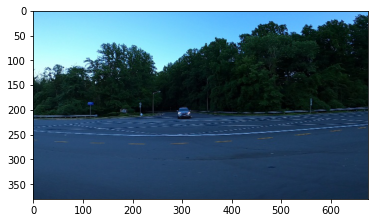

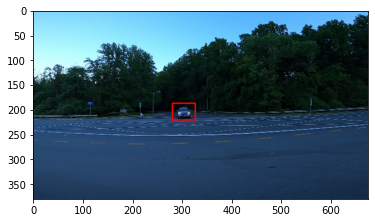

In [ ]:
for i in Data.values:
  photo=plt.imread(f'/content/data/training_images/{i[0]}')
  plt.imshow(photo)
  print('Photo shape:',photo.shape)
  print('Name,xmin,ymin,xmax,ymax:',i)
  pt1=(int(i[1]),int(i[2]))
  pt2=(int(i[3]),int(i[4]))
  color=(255,0,0)
  thickness = 2
  cv2.rectangle(photo,pt1,pt2, color, thickness)
  plt.figure()
  plt.imshow(photo)
  break

### Annotations (Check)

(380, 676, 3)
(380, 676, 3)
(380, 676, 3)


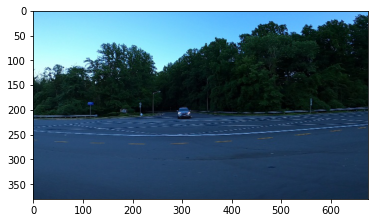

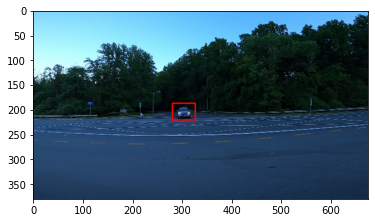

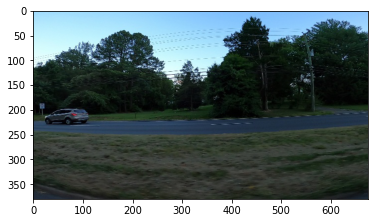

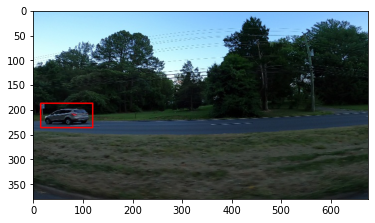

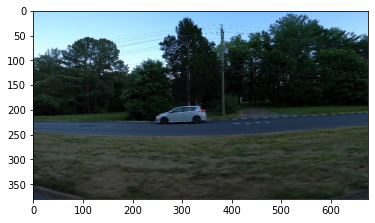

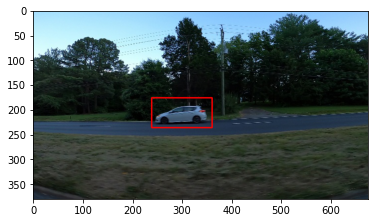

In [ ]:
for a,i in enumerate(Data.values):
  img=plt.imread('/content/data/training_images/'+i[0])
  print(img.shape)
  plt.figure()
  plt.imshow(img)
  xmin=int(i[1])
  ymin=int(i[2])
  xmax=int(i[3])
  ymax=int(i[4])
  cv2.rectangle(img,(xmin, ymin),(xmax, ymax),(255, 0, 0),2)
  plt.figure()
  plt.imshow(img)
  if a ==2:
    break

## Selective Search kullanımı

In [ ]:
cv2.setUseOptimized(True) # Optimeze
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # Selective search object

Shape: (324, 324, 3)
possible bounty boxes: 800


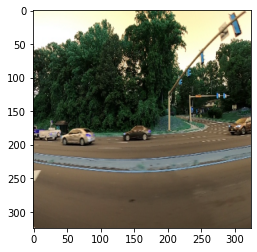

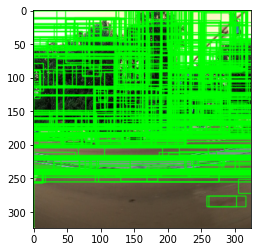

In [ ]:
im = cv2.imread('/content/data/training_images/vid_4_2020.jpg')
im=cv2.resize(im,(324,324))
plt.figure()
plt.imshow(im)
ss.setBaseImage(im) 
ss.switchToSelectiveSearchFast() 
rects = ss.process()
print('Shape:',im.shape)
print('possible bounty boxes:',len(rects))

for rect in rects:
  x, y, w, h = rect
  imOut=cv2.rectangle(im, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.figure()
plt.imshow(imOut);

# Selective serach crop the image iou>0.5 (Kullanımı)

## Selective search

In [ ]:
#Iou and selective search 
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def get_iou(bb1, bb2):

    assert bb1['x1'] < bb1['x2'] #bb1
    assert bb1['y1'] < bb1['y2']

    assert bb2['x1'] < bb2['x2'] #bb2
    assert bb2['y1'] < bb2['y2'];

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
      return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
image_liste=[]
k=0
l=0
z=0 #Loading
for a in pd.read_csv('../content/data/train_solution_bounding_boxes (1).csv').values:
  Name,xmin,ymin,xmax,ymax=a
  bb1={ #Bounty boxes
            'x1':int(xmin),
            'y1':int(ymin),
            'x2':int(xmax),
            'y2':int(ymax)
            }
  try:
    img=cv2.imread('../content/data/training_images/'+Name)
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    for i in rects:
      x, y, w, h = i # Selective bounty boxxes
      bb2={'x1':x, 
          'y1':y,
          'x2':x+w,
          'y2':y+h
          }
      img1=img[bb2['y1']:bb2['y2'],bb2['x1']:bb2['x2']] 
      img1_shape=cv2.resize(img1,(224,224))
      if k<l:
            if 0.5<get_iou(bb1,bb2):  
              image_liste.append([img1_shape,1])
              k+=1
      else:
        if 0.5<get_iou(bb1,bb2):  
          image_liste.append([img1_shape,1])
          k+=1
        else:
          image_liste.append([img1_shape,0])
          l+=1
  except Exception as e:
    print('hata var',e)
  z+=1
  print(Name,z,len(rects))

vid_4_1000.jpg 1 1101
vid_4_10000.jpg 2 1456
vid_4_10040.jpg 3 1403
vid_4_10020.jpg 4 1489
vid_4_10060.jpg 5 1315
vid_4_10100.jpg 6 1537
vid_4_10120.jpg 7 1430
vid_4_10140.jpg 8 1544
vid_4_1020.jpg 9 1117
vid_4_1040.jpg 10 1146
vid_4_10480.jpg 11 1663
vid_4_10500.jpg 12 1815
vid_4_10520.jpg 13 1725
vid_4_1060.jpg 14 1251
vid_4_10960.jpg 15 1894
vid_4_10980.jpg 16 1676
vid_4_11000.jpg 17 1754
vid_4_11020.jpg 18 1553
vid_4_11240.jpg 19 1779
vid_4_11260.jpg 20 1863
vid_4_11280.jpg 21 1846
vid_4_11380.jpg 22 1884
vid_4_11400.jpg 23 1929
vid_4_11420.jpg 24 1925
vid_4_11440.jpg 25 1880
vid_4_11900.jpg 26 1801
vid_4_11880.jpg 27 1824
vid_4_11920.jpg 28 1857
vid_4_11940.jpg 29 1947
vid_4_11960.jpg 30 1932
vid_4_11980.jpg 31 1970
vid_4_12000.jpg 32 1901
vid_4_12040.jpg 33 1979
vid_4_12100.jpg 34 1971
vid_4_12060.jpg 35 1879
vid_4_12080.jpg 36 1870
vid_4_12120.jpg 37 1821
vid_4_12140.jpg 38 1632
vid_4_12140.jpg 39 1632
vid_4_12160.jpg 40 1682
vid_4_12160.jpg 41 1682
vid_4_12160.jpg 42 1682
vid_4

In [ ]:
len(image_liste)

10581

In [ ]:
data=[]
data_label=[]
for features,label in image_liste:
  data.append(features)
  data_label.append(label)
print('transaction successful')

transaction successful


In [ ]:
print('number of photos:',len(data),'| Number of Labels:',len(data_label))

number of photos: 10581 | Number of Labels: 10581


Class: 0
Image Size: (224, 224, 3)


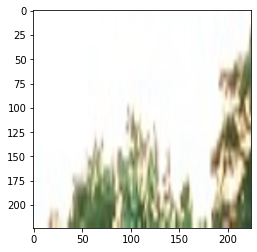

In [ ]:
i=random.randint(1,10583)
print('Class:',data_label[i])
print('Image Size:',data[i].shape)
plt.imshow(data[i]);

In [ ]:
data=np.asarray(data)
data_label=np.asarray(data_label) 

In [ ]:
print('No car image:',len(data_label[data_label==0]),'| There is a car image:',len(data_label[data_label==1]))

No car image: 5291 | There is a car image: 5290


In [ ]:
data.shape

(10581, 224, 224, 3)

In [ ]:
data_label.shape

(10581,)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(data,data_label,test_size=0.33, random_state=42)

In [ ]:
print('x_train shape:',x_train.shape)
print('x_val shape:',x_val.shape)
print('y_train shape:',y_train.shape)
print('y_val shape:',y_val.shape)

x_train shape: (7089, 224, 224, 3)
x_val shape: (3492, 224, 224, 3)
y_train shape: (7089,)
y_val shape: (3492,)


## Model

In [ ]:
base_model=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3),weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
base_model.trainable=False

In [ ]:
for i,layer in enumerate(base_model.layers):
  print(i,layer.name,'-',layer.trainable)

0 input_1 - False
1 block1_conv1 - False
2 block1_conv2 - False
3 block1_pool - False
4 block2_conv1 - False
5 block2_conv2 - False
6 block2_pool - False
7 block3_conv1 - False
8 block3_conv2 - False
9 block3_conv3 - False
10 block3_pool - False
11 block4_conv1 - False
12 block4_conv2 - False
13 block4_conv3 - False
14 block4_pool - False
15 block5_conv1 - False
16 block5_conv2 - False
17 block5_conv3 - False
18 block5_pool - False


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics='accuracy')

In [ ]:
epoch=10
hist=model.fit(x_train,y_train,epochs=epoch,validation_data=(x_val,y_val))

Epoch 1/10
222/222 [==============================] - 48s 217ms/step - loss: 0.1463 - accuracy: 0.9568 - val_loss: 0.1581 - val_accuracy: 0.9651
Epoch 2/10
222/222 [==============================] - 49s 222ms/step - loss: 0.1384 - accuracy: 0.9618 - val_loss: 0.1423 - val_accuracy: 0.9662
Epoch 3/10
222/222 [==============================] - 51s 228ms/step - loss: 0.1330 - accuracy: 0.9609 - val_loss: 0.1395 - val_accuracy: 0.9671
Epoch 4/10
222/222 [==============================] - 52s 234ms/step - loss: 0.1266 - accuracy: 0.9640 - val_loss: 0.1199 - val_accuracy: 0.9688
Epoch 5/10
222/222 [==============================] - 53s 240ms/step - loss: 0.1222 - accuracy: 0.9635 - val_loss: 0.1217 - val_accuracy: 0.9682
Epoch 6/10
222/222 [==============================] - 54s 242ms/step - loss: 0.1247 - accuracy: 0.9621 - val_loss: 0.1181 - val_accuracy: 0.9679
Epoch 7/10
222/222 [==============================] - 53s 241ms/step - loss: 0.1267 - accuracy: 0.9604 - val_loss: 0.1193 - val_ac

## Deneme

Number of possible object in this photo:  1781
how many possible bounty boxes with a class prediction of 1 are there: 81
-------------------------------------------------------------------------


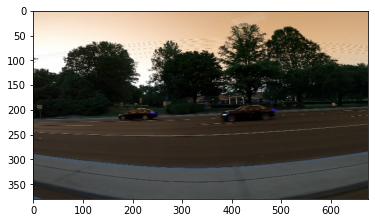

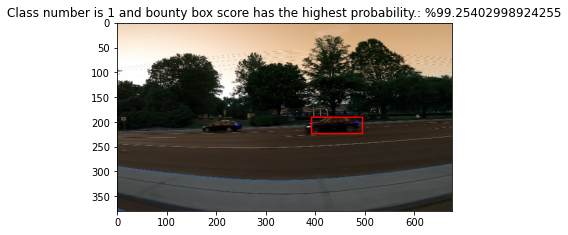

In [ ]:
car=[]
photo_path='../content/data/testing_images/vid_5_31020.jpg'
deneme_img=cv2.imread(photo_path)
ss.setBaseImage(deneme_img)
ss.switchToSelectiveSearchFast()
rects1 = ss.process()
print('Number of possible object in this photo: ',len(rects1))
for i in rects1:
  x, y, w, h = i
  bb3={'x1':x,
        'y1':y,
        'x2':x+w,
        'y2':y+h
      }
  try:
    assert bb3['x1'] < bb3['x2']
    assert bb3['y1'] < bb3['y2']
    img_data=deneme_img[bb3['y1']:bb3['y2'],bb3['x1']:bb3['x2']]
    img_data=cv2.resize(img_data,(224,224))
    tahmin=model.predict(img_data.reshape(1,224,224,3))
    if tahmin[0]>0.5:
      car.append([bb3,tahmin[0]])
    else:
      pass
  except Exception as e:
    print('error',e)
print('how many possible bounty boxes with a class prediction of 1 are there:',len(car))
print('-------------------------------------------------------------------------')
deneme_img=cv2.imread(photo_path)
car[np.argmax(np.array(car)[:,1])][0]
pt1=(car[np.argmax(np.array(car)[:,1])][0]['x1'],car[np.argmax(np.array(car)[:,1])][0]['y1'])
pt2=(car[np.argmax(np.array(car)[:,1])][0]['x2'],car[np.argmax(np.array(car)[:,1])][0]['y2'])
plt.figure()
plt.imshow(deneme_img)
cv2.rectangle(deneme_img,pt1,pt2,(255, 0, 0),2)
plt.figure()
plt.title(f'Class number is 1 and bounty box score has the highest probability.: %{car[np.argmax(np.array(car)[:,1])][1][0]*100}') 
plt.imshow(deneme_img);